# A work example for using topopy

## Topographic analysis tool

- [geolovic/topopy](https://github.com/geolovic/topopy)

  It is mainly based on [TopoToolbox](https://topotoolbox.wordpress.com/) (Topographic analysis tool) by [José Vicente Pérez Peña](https://scholar.google.es/citations?user=by5rTEUAAAAJ&hl=es) from Universidad de Granada, Granada, Spain.

## Database

- [Earth2014](http://ddfe.curtin.edu.au/models/Earth2014/) (1 Arc‐min shape, topography, bedrock and ice‐sheet models)

  Here uses the file "TRR_Earth2014.TBI2014.1min.order10800.tif" made from [Earth2014.TBI2014.1min.geod.bin](http://ddfe.curtin.edu.au/models/Earth2014/data_1min/topo_grids/Earth2014.TBI2014.1min.geod.bin) by 2_00_MakeGeotiff_Earth2014_SRTM90m
 

In [1]:
from topopy.grid import Grid, DEM
from topopy.flow import Flow
from topopy.network import Network
import gdal
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load the raster data

In [2]:
input_file = "../Data/dem/TRR_Earth2014.TBI2014.1min.order10800.tif"
#grid = Grid(input_file)
#grid.plot()
dem = DEM(input_file)
#dem_flat,dem_sill= dem.identify_flats()

### Fill sinks in a DEM using scikit-image reconstruction algorithm

In [3]:
dem_fill = dem.fill_sinks()
#dem_fill.plot()

### Calculates the flow accumulation

Graph-traversal algorithms

Reference:
- Braun, J., Willett, S.D., 2013. A very efficient O(n), implicit and parallel method to solve the stream power equation governing fluvial incision and landscape evolution. Geomorphology 180–181, 170–179. 

In [4]:
flow = Flow(dem_fill)
flowcc = flow.get_flow_accumulation()

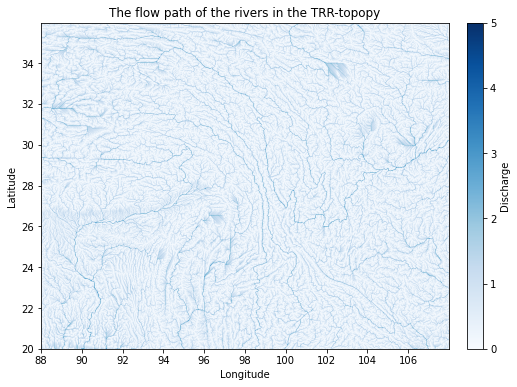

In [5]:
#flow_arr = flowcc.read_array()
if flowcc._nodata:
    mask = flowcc._array == flowcc._nodata
    flow_arr = flowcc._array.copy()
    flow_arr[mask] = flow_arr.min()
    #flow_arr = np.ma.array(flowcc._array, mask = mask)
    
extent = flowcc.get_extent()
res_area = 2
xticks_area = np.arange(extent[0],extent[1]+res_area/2,res_area)
yticks_area = np.arange(extent[2],extent[3]+res_area,res_area)


fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the rivers in the TRR-topopy')

#im = ax.imshow(flow_arr,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000)
im = ax.imshow(np.log10(flow_arr),extent=extent,cmap=cm.Blues,vmin=0, vmax=5)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cbar=plt.colorbar(im, cax=cax)
cbar= plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Discharge')

plt.savefig(('TRR_Flowpath.png'),dpi=300)
plt.show()

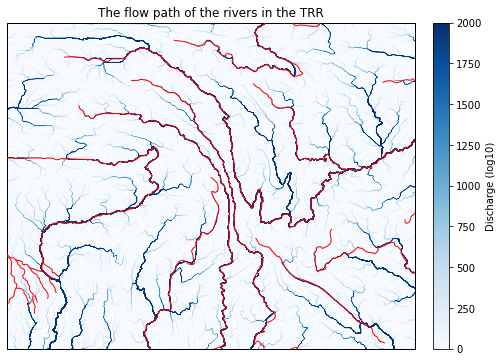

In [18]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# cartopy parameters
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                      edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),facecolor="none")
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                     edgecolor="blue", facecolor="blue")
prj_base  = ccrs.PlateCarree() 


fig = plt.figure(figsize=(8, 6))
#ax = plt.subplot(111)
ax = plt.subplot(111, projection=prj_base)
ax.set_extent(extent)

ax.set(xlabel='Longitude', ylabel='Latitude') #, yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the rivers in the TRR')

im = ax.imshow(np.flipud(flow_arr),extent=extent,cmap=cm.Blues,vmin=0, vmax=2000,transform=prj_base)
#im = ax.imshow(np.log10(flow_arr), extent=extent, transform=prj_base,
#          cmap='Blues', origin='upper', vmin=0, vmax=5)

cbar= plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Discharge (log10)')
# ax.add_feature(coastline, linewidth=1.5, edgecolor="Black", zorder=5)
ax.add_feature(rivers,    linewidth=1.0, edgecolor="r", zorder=6)
# ax.add_feature(lakes,     linewidth=0,   edgecolor="Blue", facecolor="#4477FF", zorder=7, alpha=0.5)

plt.show()
#plt.savefig(('TRR_Flowpath.png'),dpi=300)

### Plot the basin

In [7]:
#flow = Flow(dem_fill)
min_area = 0.05
threshold = int(flow._ncells * min_area)
outlets = flow.get_stream_poi(threshold, kind="outlets", coords="IND")     
row, col = flow.ind_2_cell(outlets)
outlets_x,outlets_y= flow.cell_2_xy(row, col)
print(outlets_x)

[107.98334028  89.99834028  95.01082639  98.5245625   99.95670139]


In [8]:
outlets_id_trr = [0,3,4]
outlets_x_trr = outlets_x[outlets_id_trr]
outlets_y_trr = outlets_y[outlets_id_trr]
print(outlets_x_trr)

[107.98334028  98.5245625   99.95670139]


In [9]:
basins_trr= flow.get_drainage_basins(outlets=[outlets_x_trr,outlets_y_trr],asgrid=False)

In [10]:
basins_noid = np.where(basins_trr==0)
flow_trr = flow_arr.copy()
flow_trr[basins_noid] = 0

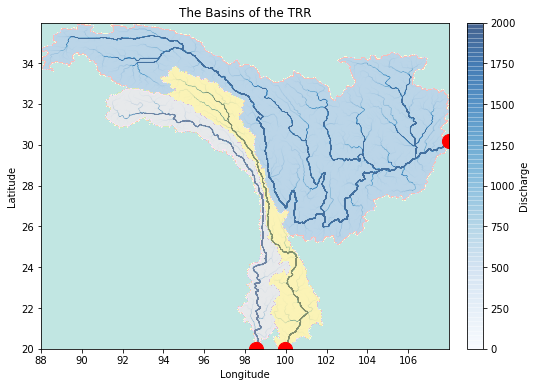

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The Basins of the TRR')

ax.imshow(basins_trr,extent=extent,cmap=cm.Set3)
ax.scatter(outlets_x_trr, outlets_y_trr,color='r',s=200)
im = ax.imshow(flow_trr,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000,alpha=0.5)

cbar= plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Discharge')

plt.savefig(('TRR_Basin.png'),dpi=300)
plt.show()

In [12]:
outlets_id_yz = 0 
outlets_yz = [outlets_x_trr[outlets_id_yz], outlets_y_trr[outlets_id_yz]]
basin_yz = flow.get_drainage_basins(outlets=outlets_yz,asgrid=False)
basin_noyzid = np.where(basin_yz==0)
basin_yzid = np.where(basin_yz==1)
flow_yz = flow_arr.copy()
flow_yz[basin_noyzid] = 0

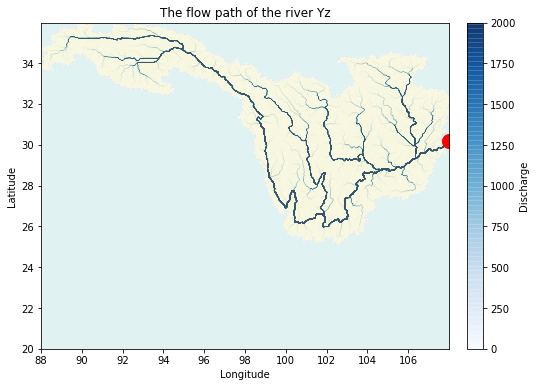

<Figure size 432x288 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the river Yz')

ax.imshow(basin_yz,extent=extent,cmap=cm.Set3)
ax.scatter(outlets_yz[0], outlets_yz[1],color='r',s=200)
im = ax.imshow(flow_yz,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000,alpha=0.8)

cbar= plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Discharge')

plt.show()
plt.savefig(('Yz_Flowpath.png'),dpi=300)

### Basin Network

In [14]:
min_area = 0.01
threshold = int(flow._ncells * min_area)
basin_network = Network(dem=dem_fill,flow=flow,threshold=threshold)

In [15]:
basin_network._ax.max()

84.71953739469043

In [16]:
streams_or = basin_network.get_stream_order(kind='shreeve',asgrid=False)